In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(level=logging.WARNING,
                    filename="logs.log",
                    filemode="a",
                    format="%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s",
                    datefmt="%H:%M:%S")
import pickle
import joblib
import mlflow
import mlflow.sklearn
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.impute  import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif,chi2,f_classif,SelectKBest,VarianceThreshold
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,roc_auc_score,roc_curve,auc,precision_score,recall_score,f1_score,precision_recall_curve,average_precision_score,make_scorer

import sqlalchemy as sa
import pymysql

db_credentials = {
    'username': 'root',
    'password': 'Mysql2024',
    'host': 'localhost:3306',
    'database': 'world',
}

# MySQL database URL using the PyMySQL dialect
mysql_url = f"mysql+pymysql://{db_credentials['username']}:{db_credentials['password']}@{db_credentials['host']}/{db_credentials['database']}"

# Create a SQLAlchemy engine
income_db = sa.create_engine(mysql_url)

from imblearn.over_sampling import SMOTE,SMOTENC


In [2]:
df = pd.read_csv("../DataSet/healthcare-dataset-stroke-data.csv")

df.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [3]:
df.shape

(5110, 12)

In [4]:
df.drop(columns=['id'],axis=1,inplace=True)

In [5]:
df.duplicated().sum()

0

In [6]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [7]:
(df.isnull().sum() / df.shape[0] ).round(3)* 100

gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  3.9
smoking_status       0.0
stroke               0.0
dtype: float64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


In [10]:
df_num = df.columns.get_indexer_for(df.select_dtypes(exclude="object").columns).tolist()
df_num

[1, 2, 3, 7, 8, 10]

In [11]:
def numerical_col(data):
    for i in data:
        plt.figure(figsize=[10,3])


        plt.subplot(1,2,1)
        sns.distplot(x=df[i],label=df[i].skew().round(2))
        plt.legend()
        plt.subplot(1,2,2)
        sns.boxplot(x=df[i])
        plt.show()

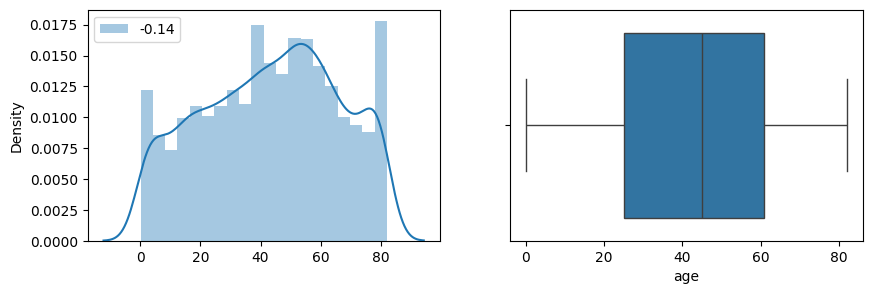

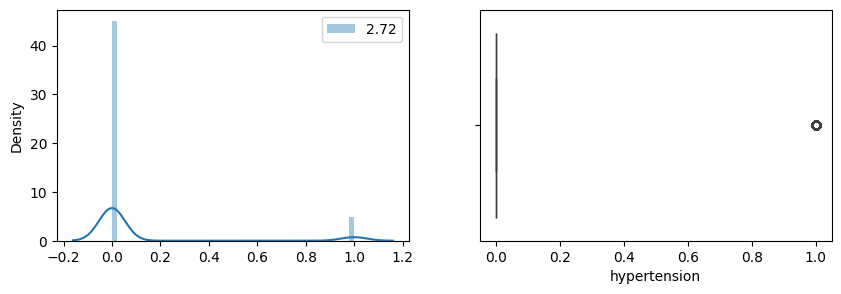

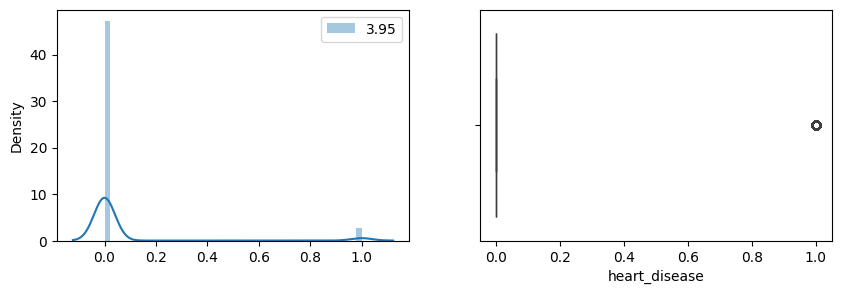

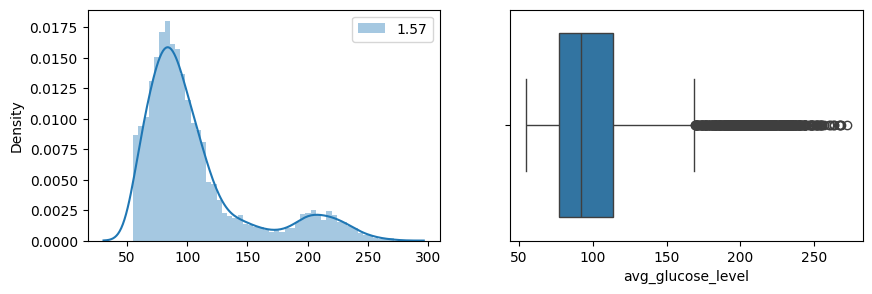

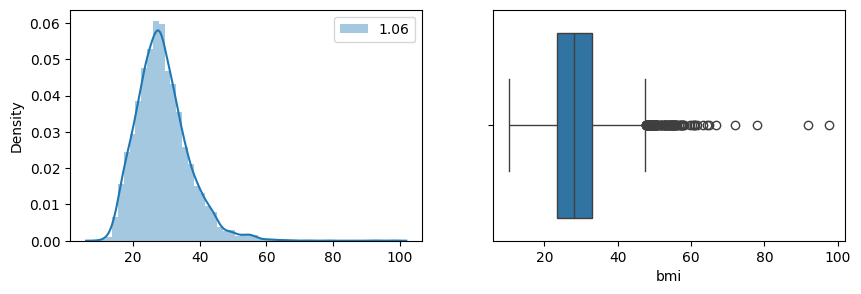

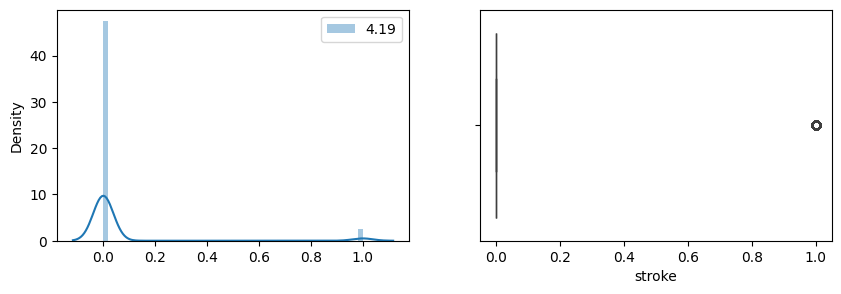

In [12]:
numerical_col(df.select_dtypes(exclude="object").columns)

In [13]:
def iqr_data(data):
    col =[]
    q1_list =[]
    q2_list = []
    upper = []
    lower =[]

    for i in data:
        q1 = df[i].quantile(0.25)
        q3 = df[i].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)

        col.append(i)
        q1_list.append(q1)
        q2_list.append(q3)
        lower.append(lower_bound)
        upper.append(upper_bound)

    data = {"Column":col ,"Q1": q1_list , "Q2": q2_list , "Upper": upper , "Lower": lower}

    iqr = pd.DataFrame(data)

    return iqr


In [14]:
iqr_data(df.select_dtypes(exclude="object").columns)

,Column,Q1,Q2,Upper,Lower
0,age,25.000,61.00,115.0000,-29.0000
1,hypertension,0.000,0.00,0.0000,0.0000
2,heart_disease,0.000,0.00,0.0000,0.0000
3,avg_glucose_level,77.245,114.09,169.3575,21.9775
4,bmi,23.500,33.10,47.5000,9.1000
5,stroke,0.000,0.00,0.0000,0.0000


In [15]:
#avg_glucose_level
df['avg_glucose_level'] = np.where(df['avg_glucose_level']>169.3575,df['avg_glucose_level'].median(),df['avg_glucose_level'])

#bmi
df['bmi'] = np.where(df['bmi']>47.5,df['bmi'].median(),df['bmi'])



In [16]:
df_cat = df.columns.get_indexer_for(df.select_dtypes(include="object").columns).tolist()
df_cat

[0, 4, 5, 6, 9]

In [17]:
def categorical_col(data):
    for i in data:
        plt.figure(figsize=[10,3])
        plt.subplot(1,2,1)
        sns.countplot(x=df[i])
        plt.xticks(rotation=90)
        plt.subplot(1,2,2)
        sns.countplot(x=df[i],hue=df['stroke'])
        plt.xticks(rotation=90)
        plt.show()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


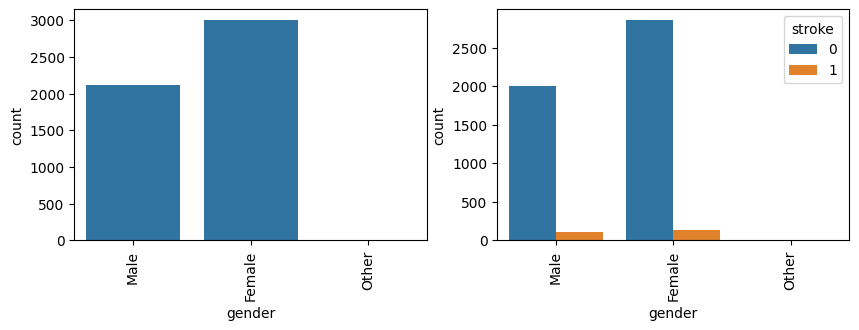

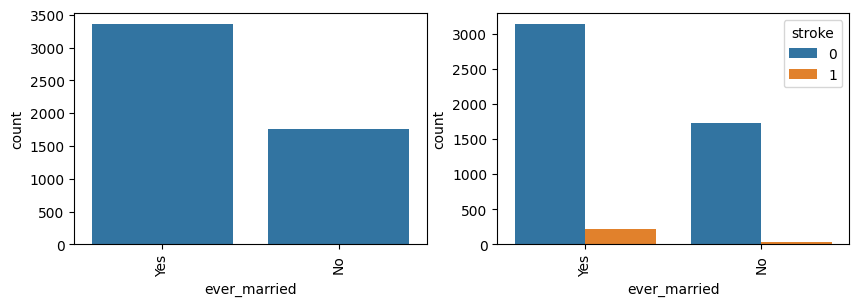

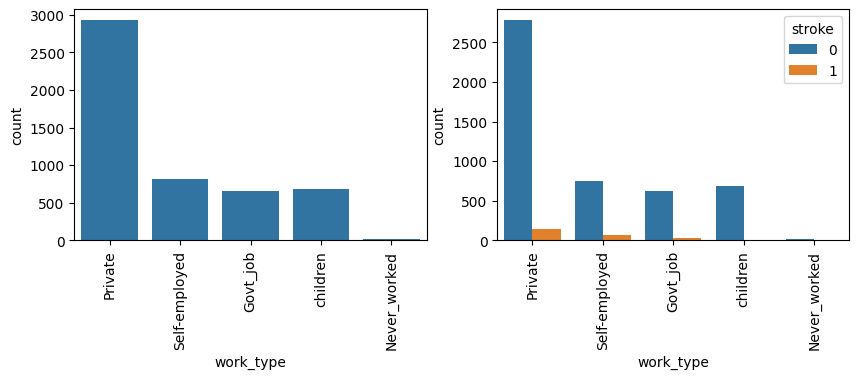

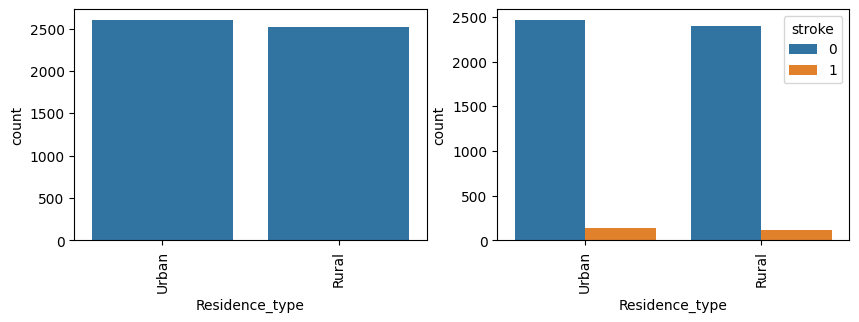

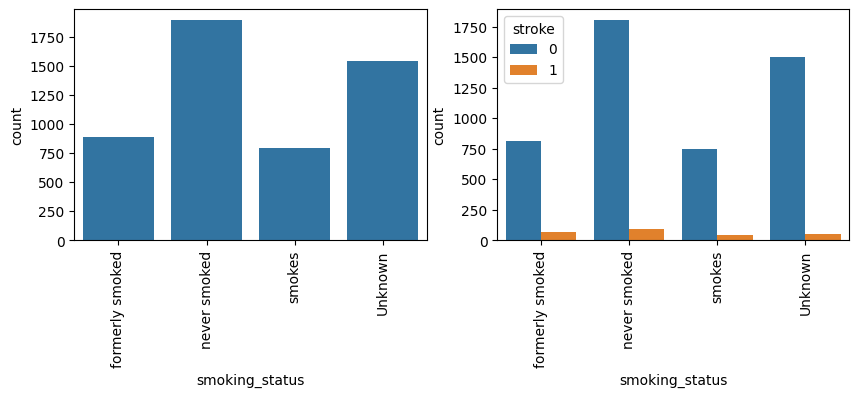

In [19]:
categorical_col(df.select_dtypes(include="object").columns)

In [20]:
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

In [21]:
X = df.drop(['stroke'],axis=1)
y = df['stroke']

In [22]:
x_train ,x_test,y_train,y_test = train_test_split(X,y,random_state=20,test_size=0.2,stratify=y)

In [23]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

stroke
0    0.951321
1    0.048679
Name: proportion, dtype: float64
stroke
0    0.951076
1    0.048924
Name: proportion, dtype: float64


In [24]:
cat_ind = x_train.columns.get_indexer_for(x_train.select_dtypes(include="object").columns).tolist()

In [25]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4088 entries, 1176 to 3336
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4088 non-null   object 
 1   age                4088 non-null   float64
 2   hypertension       4088 non-null   int64  
 3   heart_disease      4088 non-null   int64  
 4   ever_married       4088 non-null   object 
 5   work_type          4088 non-null   object 
 6   Residence_type     4088 non-null   object 
 7   avg_glucose_level  4088 non-null   float64
 8   bmi                4088 non-null   float64
 9   smoking_status     4088 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 351.3+ KB


In [26]:
smotenc = SMOTENC(categorical_features=cat_ind,sampling_strategy="auto")

x_train_smt , y_train_smt = smotenc.fit_resample(x_train,y_train)

In [27]:
print(y_train.value_counts(normalize=True))

print(y_train_smt.value_counts(normalize=True))

stroke
0    0.951321
1    0.048679
Name: proportion, dtype: float64
stroke
0    0.5
1    0.5
Name: proportion, dtype: float64


In [28]:
x_num = x_train.columns.get_indexer_for(x_train.select_dtypes(exclude="object").columns).tolist()


x_cat = x_train.columns.get_indexer_for(x_train.select_dtypes(include="object").columns).tolist()


In [29]:
pd.DataFrame(x_train)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
1176,Female,29.00,0,0,No,Govt_job,Rural,57.020,43.0,formerly smoked
758,Male,47.00,0,0,Yes,Govt_job,Rural,74.800,23.5,never smoked
1490,Female,49.00,1,0,Yes,Govt_job,Rural,107.910,25.0,Unknown
2468,Male,77.00,0,0,Yes,Self-employed,Urban,83.060,27.0,Unknown
1137,Male,1.72,0,0,No,children,Urban,75.790,17.6,Unknown
...,...,...,...,...,...,...,...,...,...,...
487,Male,21.00,0,0,Yes,Private,Rural,98.010,24.2,Unknown
2273,Male,51.00,0,0,Yes,Private,Rural,91.885,35.0,never smoked
1288,Male,38.00,0,0,Yes,Private,Rural,61.270,44.0,Unknown
2520,Male,26.00,0,0,No,Self-employed,Urban,91.885,31.9,formerly smoked


In [30]:
pd.DataFrame(x_test)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
2334,Male,73.0,0,0,No,Govt_job,Rural,79.590,31.4,smokes
432,Female,63.0,0,0,Yes,Govt_job,Rural,79.920,28.1,smokes
2781,Female,16.0,0,0,No,Never_worked,Urban,84.400,25.9,never smoked
1145,Female,7.0,0,0,No,children,Urban,88.600,17.4,Unknown
1297,Female,79.0,0,0,No,Self-employed,Rural,71.980,36.4,never smoked
...,...,...,...,...,...,...,...,...,...,...
2398,Female,51.0,0,0,Yes,Govt_job,Urban,86.250,29.0,never smoked
4429,Female,40.0,0,0,Yes,Private,Urban,86.780,35.5,smokes
2149,Male,39.0,0,0,Yes,Private,Urban,91.885,39.5,never smoked
98,Male,57.0,1,0,Yes,Govt_job,Urban,78.920,27.7,formerly smoked


Pipeline

In [31]:
pipe1 = ColumnTransformer([
    ("simple_num",SimpleImputer(strategy="median"),x_num),
    ("simple_cat",SimpleImputer(strategy="most_frequent"),x_cat)
],remainder="passthrough")

In [32]:
pipe2 = ColumnTransformer([
    ('onehot',OneHotEncoder(handle_unknown='ignore',sparse_output=False,sparse=False),x_cat)
],remainder='passthrough')

In [33]:
pipe3 = ColumnTransformer([
    ('minmax',MinMaxScaler(),x_num)
],remainder='passthrough')

In [34]:
pipe4 = SelectKBest(score_func=mutual_info_classif,k=6)

In [35]:
pipe5 = PCA(n_components=5)

In [36]:
pipe6 = LogisticRegression()

In [37]:
pipeline_lre = Pipeline([
    ("pipe1",pipe1),
    ("pipe2",pipe2),
    ("pipe3",pipe3),
    ("pipe4",pipe4),
    ("pipe5",pipe5),
    ("pipe6",pipe6)
])

In [38]:
pipeline_lre

Pipeline(steps=[('pipe1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simple_num',
                                                  SimpleImputer(strategy='median'),
                                                  [1, 2, 3, 7, 8]),
                                                 ('simple_cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [0, 4, 5, 6, 9])])),
                ('pipe2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False,
                                                                sparse_output=False),
                                                  [0, 4, 5, 6, 9])])),
                ('pipe3',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmax', MinMaxScaler(),
                                                  [1, 2, 3, 7, 8])])),
                ('pipe4',
                 SelectKBest(k=6,
                             score_func=<function mutual_info_classif at 0x0000017372CACD60>)),
                ('pipe5', PCA(n_components=5)),
                ('pipe6', LogisticRegression())])

In [39]:
transformed_data = pipe2.fit_transform(x_train)

pd.DataFrame(transformed_data)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,29.00,0.0,0.0,57.020,43.0
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,47.00,0.0,0.0,74.800,23.5
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,49.00,1.0,0.0,107.910,25.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,77.00,0.0,0.0,83.060,27.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.72,0.0,0.0,75.790,17.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,21.00,0.0,0.0,98.010,24.2
4084,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,51.00,0.0,0.0,91.885,35.0
4085,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,38.00,0.0,0.0,61.270,44.0
4086,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,26.00,0.0,0.0,91.885,31.9


In [40]:
x_train

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
1176,Female,29.00,0,0,No,Govt_job,Rural,57.020,43.0,formerly smoked
758,Male,47.00,0,0,Yes,Govt_job,Rural,74.800,23.5,never smoked
1490,Female,49.00,1,0,Yes,Govt_job,Rural,107.910,25.0,Unknown
2468,Male,77.00,0,0,Yes,Self-employed,Urban,83.060,27.0,Unknown
1137,Male,1.72,0,0,No,children,Urban,75.790,17.6,Unknown
...,...,...,...,...,...,...,...,...,...,...
487,Male,21.00,0,0,Yes,Private,Rural,98.010,24.2,Unknown
2273,Male,51.00,0,0,Yes,Private,Rural,91.885,35.0,never smoked
1288,Male,38.00,0,0,Yes,Private,Rural,61.270,44.0,Unknown
2520,Male,26.00,0,0,No,Self-employed,Urban,91.885,31.9,formerly smoked


In [41]:
transformed_data = pipe2.transform(x_test)

pd.DataFrame(transformed_data)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,73.0,0.0,0.0,79.590,31.4
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,63.0,0.0,0.0,79.920,28.1
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,16.0,0.0,0.0,84.400,25.9
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,7.0,0.0,0.0,88.600,17.4
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,79.0,0.0,0.0,71.980,36.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,51.0,0.0,0.0,86.250,29.0
1018,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,40.0,0.0,0.0,86.780,35.5
1019,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,39.0,0.0,0.0,91.885,39.5
1020,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,57.0,1.0,0.0,78.920,27.7


In [42]:
with mlflow.start_run(nested=True):

    mlflow.log_text("V1.0","Version")
    mlflow.log_text("with out smote",'smote')
    mlflow.log_text("Logistic","Algorithm")

    x_train = pipe2.fit_transform(x_train)  
    x_test = pipe2.transform(x_test)    

    pipeline_lre.fit(x_train,y_train)

    mlflow.sklearn.log_model(pipeline_lre,'LogisticRegression')

    y_pred = pipeline_lre.predict(x_test)

    train_score = pipeline_lre.score(x_train,y_train)
    test_score = pipeline_lre.score(x_test,y_test)

    acc_score = accuracy_score(y_test,y_pred)
    pre_score = precision_score(y_test,y_pred)
    re_score = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    clf_rpt = classification_report(y_test,y_pred)
    print(clf_rpt)
    cnf_mat = confusion_matrix(y_test,y_pred)
    print(cnf_mat)

    mlflow.log_metric("train_score",train_score)
    mlflow.log_metric("test_score",test_score)
    mlflow.log_metric("acc_score",acc_score)
    mlflow.log_metric("pre_score",pre_score)
    mlflow.log_metric("re_score",re_score)
    mlflow.log_metric("f1_score",f1)

    mlflow.autolog()

mlflow.end_run()


2024/01/22 22:01:49 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022

[[972   0]
 [ 50   0]]


2024/01/22 22:01:50 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/01/22 22:01:51 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for sklearn: c:\Users\shubh\anaconda3\envs\drug\Lib\distutils\core.py


In [43]:
pd.DataFrame(x_train_smt)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Female,29.000000,0,0,No,Govt_job,Rural,57.020000,43.000000,formerly smoked
1,Male,47.000000,0,0,Yes,Govt_job,Rural,74.800000,23.500000,never smoked
2,Female,49.000000,1,0,Yes,Govt_job,Rural,107.910000,25.000000,Unknown
3,Male,77.000000,0,0,Yes,Self-employed,Urban,83.060000,27.000000,Unknown
4,Male,1.720000,0,0,No,children,Urban,75.790000,17.600000,Unknown
...,...,...,...,...,...,...,...,...,...,...
7773,Male,48.079769,0,0,Yes,Private,Urban,74.072908,20.890866,Unknown
7774,Female,75.044660,0,0,Yes,Private,Urban,109.791947,28.055340,formerly smoked
7775,Female,53.061253,0,0,Yes,Private,Rural,104.575712,28.163647,smokes
7776,Male,81.551752,0,0,Yes,Private,Urban,105.244386,25.694785,Unknown


In [44]:
pd.DataFrame(x_test)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,73.0,0.0,0.0,79.590,31.4
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,63.0,0.0,0.0,79.920,28.1
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,16.0,0.0,0.0,84.400,25.9
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,7.0,0.0,0.0,88.600,17.4
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,79.0,0.0,0.0,71.980,36.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,51.0,0.0,0.0,86.250,29.0
1018,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,40.0,0.0,0.0,86.780,35.5
1019,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,39.0,0.0,0.0,91.885,39.5
1020,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,57.0,1.0,0.0,78.920,27.7


In [45]:
with mlflow.start_run(nested=True):

    mlflow.log_text("V1.1","Version")
    mlflow.log_text("with smote",'smote')
    mlflow.log_text("Logistic","Algorithm")

    x_train_smt = pipe2.fit_transform(x_train_smt)  
    # x_test = pipe2.transform(x_test)    

    pipeline_lre.fit(x_train_smt,y_train_smt)

    mlflow.sklearn.log_model(pipeline_lre,'LogisticRegression')

    y_pred = pipeline_lre.predict(x_test)

    train_score = pipeline_lre.score(x_train_smt,y_train_smt)
    test_score = pipeline_lre.score(x_test,y_test)

    acc_score = accuracy_score(y_test,y_pred)
    pre_score = precision_score(y_test,y_pred)
    re_score = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    clf_rpt = classification_report(y_test,y_pred)
    print(clf_rpt)
    cnf_mat = confusion_matrix(y_test,y_pred)
    print(cnf_mat)

    mlflow.log_metric("train_score",train_score)
    mlflow.log_metric("test_score",test_score)
    mlflow.log_metric("acc_score",acc_score)
    mlflow.log_metric("pre_score",pre_score)
    mlflow.log_metric("re_score",re_score)
    mlflow.log_metric("f1_score",f1)

    mlflow.autolog()

mlflow.end_run()


2024/01/22 22:02:00 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2024/01/22 22:02:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


              precision    recall  f1-score   support

           0       0.99      0.75      0.85       972
           1       0.14      0.78      0.23        50

    accuracy                           0.75      1022
   macro avg       0.56      0.76      0.54      1022
weighted avg       0.94      0.75      0.82      1022

[[726 246]
 [ 11  39]]


In [46]:
random_state = 0
criterion = "gini"
splitter = "best"

pipe7 = DecisionTreeClassifier(random_state=0,criterion=criterion,splitter=splitter)

pipeline_dt = Pipeline([
    ('pipe1',pipe1),
    ('pipe2',pipe2),
    ('pipe3',pipe3),
    ('pipe4',pipe4),
    ('pipe5',pipe5),
    ('pipe7',pipe7)
])

In [47]:
with mlflow.start_run(nested=True):

    mlflow.log_text("V1.2","Version")
    mlflow.log_text("with smote",'smote')
    mlflow.log_text("DecisionTree","Algorithm")

    x_train_smt = pipe2.fit_transform(x_train_smt)  
    # x_test = pipe2.transform(x_test)    

    pipeline_dt.fit(x_train_smt,y_train_smt)

    mlflow.sklearn.log_model(pipeline_dt,'LogisticRegression')

    y_pred = pipeline_dt.predict(x_test)

    train_score = pipeline_dt.score(x_train_smt,y_train_smt)
    test_score = pipeline_dt.score(x_test,y_test)

    acc_score = accuracy_score(y_test,y_pred)
    pre_score = precision_score(y_test,y_pred)
    re_score = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    clf_rpt = classification_report(y_test,y_pred)
    print(clf_rpt)
    cnf_mat = confusion_matrix(y_test,y_pred)
    print(cnf_mat)

    mlflow.log_metric("train_score",train_score)
    mlflow.log_metric("test_score",test_score)
    mlflow.log_metric("acc_score",acc_score)
    mlflow.log_metric("pre_score",pre_score)
    mlflow.log_metric("re_score",re_score)
    mlflow.log_metric("f1_score",f1)

    mlflow.autolog()

mlflow.end_run()


ValueError: X has 21 features, but ColumnTransformer is expecting 26 features as input.